<a href="https://colab.research.google.com/github/JoshuaChung93/Cryptocurrency-trading-bot/blob/main/BTC_IBS_strategy_backtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df0 = pd.read_csv('/content/drive/MyDrive/BTC historical dataset/BTC-Hourly.csv', index_col=0)

In [3]:
df = df0.copy()

In [4]:
# 시계열에 맞게 인덱스를 거꾸로 돌려줍니다
df = df.loc[::-1].reset_index(drop=True)
df.head()

,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,2018-05-15 06:00:00,BTC/USD,8733.86,8796.68,8707.28,8740.99,4906603.14,559.93
1,2018-05-15 07:00:00,BTC/USD,8740.99,8766.00,8721.11,8739.00,2390398.89,273.58
2,2018-05-15 08:00:00,BTC/USD,8739.00,8750.27,8660.53,8728.49,7986062.84,917.79
3,2018-05-15 09:00:00,BTC/USD,8728.49,8754.40,8701.35,8708.32,1593991.98,182.62
4,2018-05-15 10:00:00,BTC/USD,8708.32,8865.00,8695.11,8795.90,11101273.74,1260.69


In [5]:
# 인덱스 이름 설정
df.index.name = 'Bar numbers'
df.head()

,date,symbol,open,high,low,close,Volume BTC,Volume USD
Bar numbers,,,,,,,,
0,2018-05-15 06:00:00,BTC/USD,8733.86,8796.68,8707.28,8740.99,4906603.14,559.93
1,2018-05-15 07:00:00,BTC/USD,8740.99,8766.00,8721.11,8739.00,2390398.89,273.58
2,2018-05-15 08:00:00,BTC/USD,8739.00,8750.27,8660.53,8728.49,7986062.84,917.79
3,2018-05-15 09:00:00,BTC/USD,8728.49,8754.40,8701.35,8708.32,1593991.98,182.62
4,2018-05-15 10:00:00,BTC/USD,8708.32,8865.00,8695.11,8795.90,11101273.74,1260.69


In [6]:
# 필요 없는 열 드랍하기
df.drop(['Volume BTC','Volume USD'], axis=1, inplace=True)
df.tail()

,date,symbol,open,high,low,close
Bar numbers,,,,,,
33254,2022-02-28 20:00:00,BTC/USD,41361.99,41971.00,41284.11,41914.97
33255,2022-02-28 21:00:00,BTC/USD,41917.09,41917.09,41542.60,41659.53
33256,2022-02-28 22:00:00,BTC/USD,41657.23,44256.08,41650.29,42907.32
33257,2022-02-28 23:00:00,BTC/USD,43085.30,43364.81,42892.37,43178.98
33258,2022-03-01 00:00:00,BTC/USD,43221.71,43626.49,43185.48,43312.27


## 백테스트 기간 주가 그래프

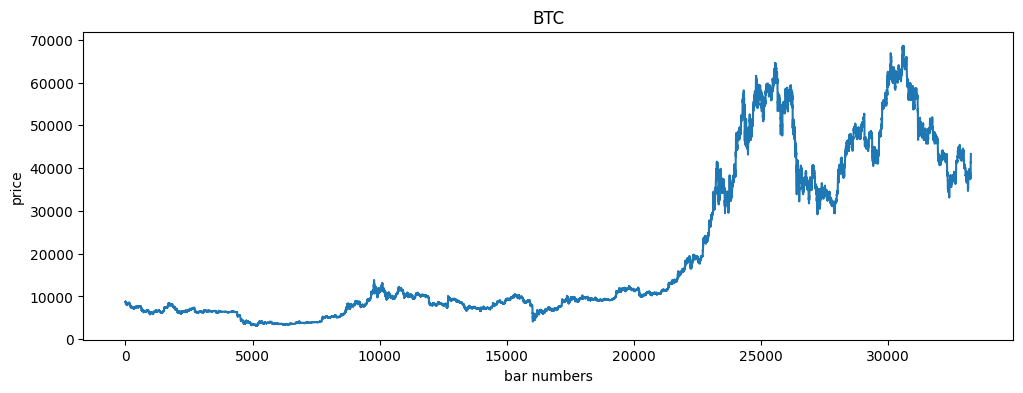

In [8]:
plt.style.use(['default'])
df['close'].plot(figsize=(12,4), title='BTC')
plt.xlabel('bar numbers')
plt.ylabel('price')

plt.show()

In [9]:
# 100SMA, 200SMA 칼럼 생성
df['200SMA'] = df['close'].rolling(4800).mean()
df['100SMA'] = df['close'].rolling(2400).mean()
df.head()

,date,symbol,open,high,low,close,long,short,200SMA,100SMA
Bar numbers,,,,,,,,,,
0,2018-05-15 06:00:00,BTC/USD,8733.86,8796.68,8707.28,8740.99,False,False,NaN,NaN
1,2018-05-15 07:00:00,BTC/USD,8740.99,8766.00,8721.11,8739.00,False,False,NaN,NaN
2,2018-05-15 08:00:00,BTC/USD,8739.00,8750.27,8660.53,8728.49,False,False,NaN,NaN
3,2018-05-15 09:00:00,BTC/USD,8728.49,8754.40,8701.35,8708.32,True,False,NaN,NaN
4,2018-05-15 10:00:00,BTC/USD,8708.32,8865.00,8695.11,8795.90,False,False,NaN,NaN


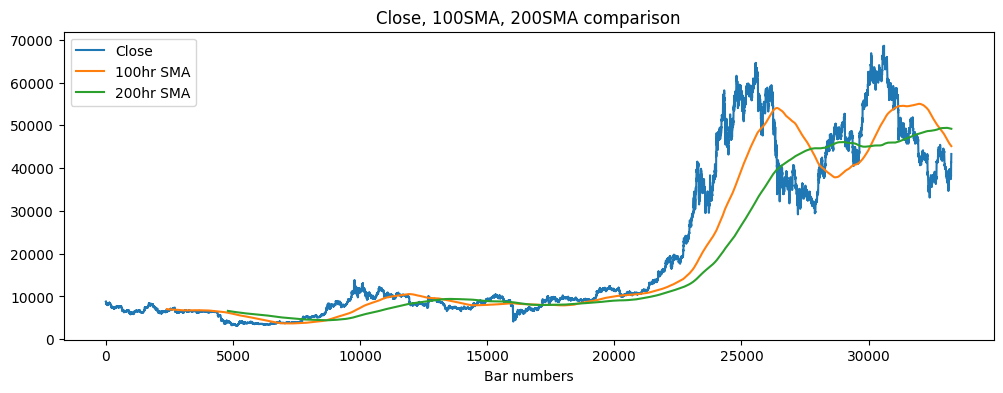

In [10]:
df['close'].plot(figsize=(12,4), label='Close')
df['100SMA'].plot(label='100hr SMA')
df['200SMA'].plot(label='200hr SMA')

plt.title('Close, 100SMA, 200SMA comparison')
plt.legend()


# make signal column

In [11]:
# 진입조건을 위한 칼럼 생성
df['long'] = (df['close'] - df['low'])/(df['high'] - df['low']) < 0.2
df['short'] = (df['close'] - df['low'])/(df['high'] - df['low']) > 0.8
df['long_con'] = (df['close']) <= (1.05*df['100SMA'])
df['short_con'] = (df['close']) >= (0.95*df['100SMA'])

In [11]:
# long 진입청산 컬럼 생성
df['entry_long'] = np.where((df['long']==True)&(df['long_con']==True), 1.0,0.0) # 진입신호
df['exit_long'] = np.where(df['short']==True, 1.0,0.0) # 청산신호

In [12]:
# 포지션 보유 여부 컬럼 생성
df['position'] = df['entry_long'] - df['exit_long']

# remove duplicated position signal
lastseen = 0

for n,el in enumerate(df["position"]):
    if lastseen == 0 and el == -1:
        df.loc[n,'position'] = 0
    
    if (el in [1, -1] and el != lastseen) or lastseen == 0:
        lastseen = el
    else:
        df.loc[n,"position"] = 0
# # deal with edge case
# df.loc[7,'position'] = 0

In [13]:
df.loc[(df.position==1)|(df.position==-1),:]

,date,symbol,open,high,low,close,200SMA,100SMA,long,short,long_con,short_con,entry_long,exit_long,position
Bar numbers,,,,,,,,,,,,,,,
2408,2018-08-23 14:00:00,BTC/USD,6426.14,6495.00,6426.14,6439.74,NaN,7021.826508,True,False,True,False,1.0,0.0,1.0
2415,2018-08-23 21:00:00,BTC/USD,6414.54,6480.00,6414.54,6472.57,NaN,7015.744888,False,True,True,False,0.0,1.0,-1.0
2420,2018-08-24 02:00:00,BTC/USD,6498.31,6519.83,6494.31,6499.15,NaN,7011.855821,True,False,True,False,1.0,0.0,1.0
2422,2018-08-24 04:00:00,BTC/USD,6493.65,6507.99,6473.94,6501.31,NaN,7010.439483,False,True,True,False,0.0,1.0,-1.0
2429,2018-08-24 11:00:00,BTC/USD,6540.00,6570.00,6532.81,6537.99,NaN,7005.357658,True,False,True,False,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33232,2022-02-27 22:00:00,BTC/USD,37408.05,37934.27,37349.35,37832.76,49235.089852,45351.829508,False,True,True,False,0.0,1.0,-1.0
33243,2022-02-28 09:00:00,BTC/USD,38345.77,38592.84,38114.65,38125.95,49217.574175,45257.377896,True,False,True,False,1.0,0.0,1.0
33244,2022-02-28 10:00:00,BTC/USD,38114.28,38474.51,38104.13,38404.20,49216.121967,45248.984108,False,True,True,False,0.0,1.0,-1.0


# Visualize

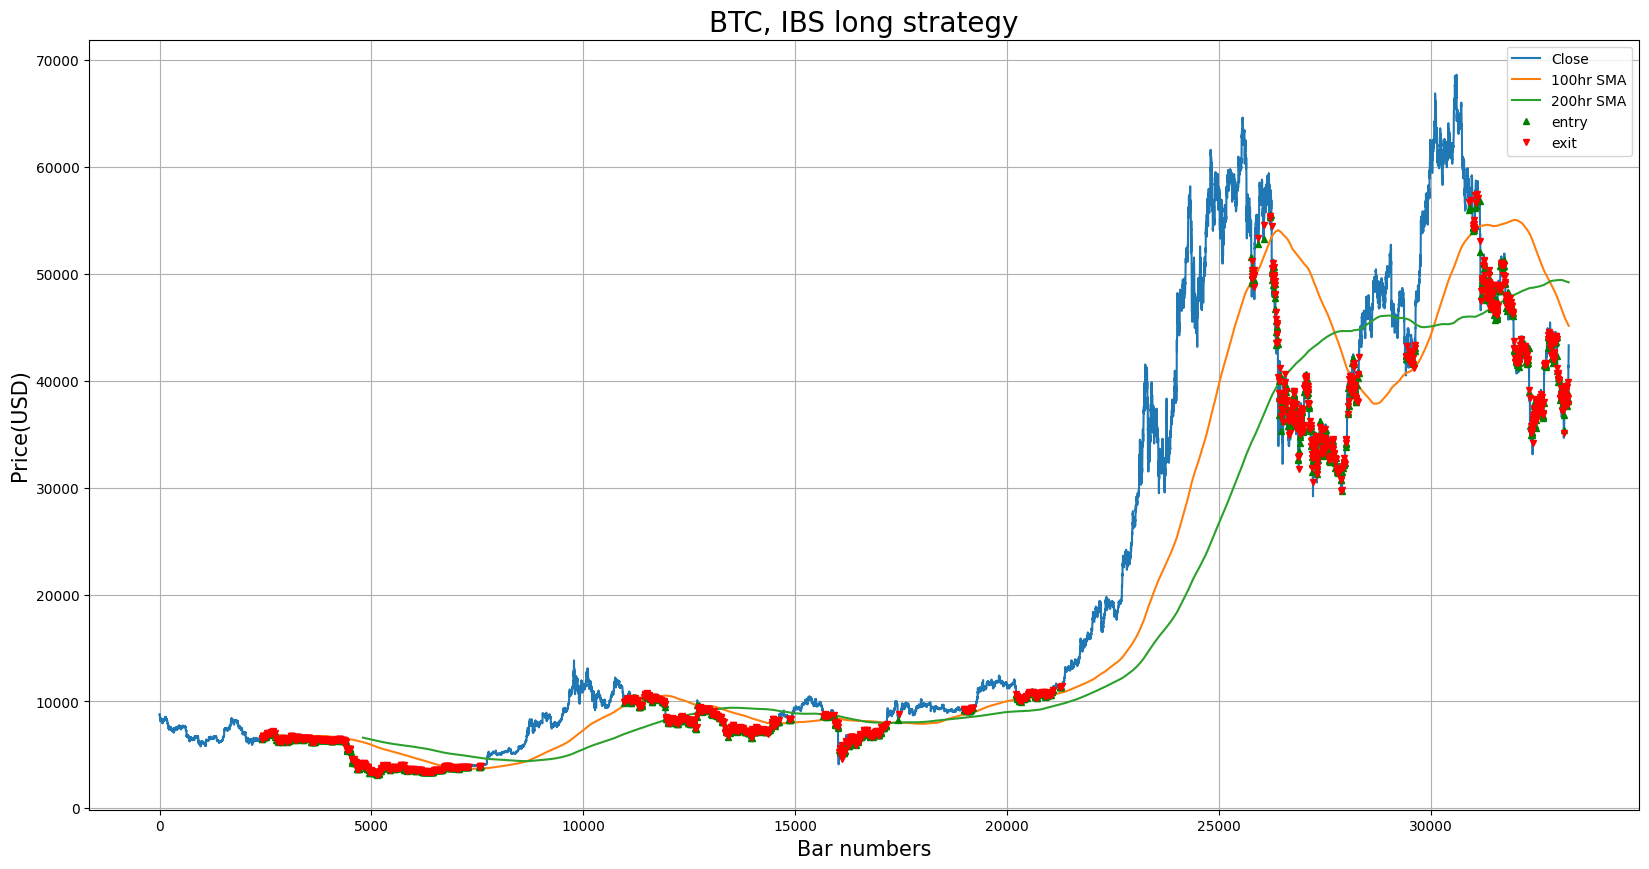

In [26]:
# plot close, 100SMA, 200SMA
df['close'].plot(figsize=(20,10), label='Close')
df['100SMA'].plot(label='100hr SMA')
df['200SMA'].plot(label='200hr SMA')

# plot 'entry' signals
plt.plot(df.loc[df['position']==1,:].index, df.loc[df['position']==1.0,'close'], '^', markersize = 5, color = 'g', label = 'entry')

# plot 'exit' signals
plt.plot(df.loc[df['position']==-1,:].index, df.loc[df['position']==-1.0,'close'], 'v', markersize = 5,  color = 'r', label = 'exit')
plt.ylabel('Price(USD)', fontsize = 15 )
plt.xlabel('Bar numbers', fontsize = 15 )
plt.title('BTC, IBS long strategy', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

# Calculate the return

In [15]:
# make dataframe with position == 1 or position == -1
df2 = df.loc[(df.position==1)|(df.position==-1),:]
df2['exit_close'] = df2['close'].shift(-1)
# calculate return
df2['ror'] = df2['exit_close']/df2['close']

<ipython-input-15-c0217c67bcb2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['exit_close'] = df2['close'].shift(-1)
<ipython-input-15-c0217c67bcb2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['ror'] = df2['exit_close']/df2['close']


In [16]:
# copy df2 ror to df ror column
df['ror'] = df2['ror']
df['ror'].fillna(1,inplace=True)
# calculate accumulated ror
df['total'] = df['ror'].cumprod()

                            date   symbol      open      high       low  \
Bar numbers                                                               
0            2018-05-15 06:00:00  BTC/USD   8733.86   8796.68   8707.28   
1            2018-05-15 07:00:00  BTC/USD   8740.99   8766.00   8721.11   
2            2018-05-15 08:00:00  BTC/USD   8739.00   8750.27   8660.53   
3            2018-05-15 09:00:00  BTC/USD   8728.49   8754.40   8701.35   
4            2018-05-15 10:00:00  BTC/USD   8708.32   8865.00   8695.11   
...                          ...      ...       ...       ...       ...   
33254        2022-02-28 20:00:00  BTC/USD  41361.99  41971.00  41284.11   
33255        2022-02-28 21:00:00  BTC/USD  41917.09  41917.09  41542.60   
33256        2022-02-28 22:00:00  BTC/USD  41657.23  44256.08  41650.29   
33257        2022-02-28 23:00:00  BTC/USD  43085.30  43364.81  42892.37   
33258        2022-03-01 00:00:00  BTC/USD  43221.71  43626.49  43185.48   

                close   

In [21]:
# calculate performance indicator

# return trading days
trade_day = int(len(df.index)/24)
result = round((df['total'].iat[-1] / df['total'].iat[0] - 1)*100, 3)

print(trade_day,'days / ', result,'return(%)')

1385 days /  518.66 return(%)


In [23]:
# calculate CAGR
total_profit = (df['total'].iat[-1] / df['total'].iat[0])
cagr = round((total_profit**(1/(trade_day/365))-1)*100,2)

# calculate MDD
arr_v = np.array(df['total'])
peak_lower = np.argmax(np.maximum.accumulate(arr_v) - arr_v)
peak_upper = np.argmax(arr_v[:peak_lower])

mdd = round((arr_v[peak_lower] - arr_v[peak_upper]) / arr_v[peak_upper]*100,3)

print('CAGR:',cagr,'MDD:',mdd)

CAGR:  61.65 MDD:  -46.586


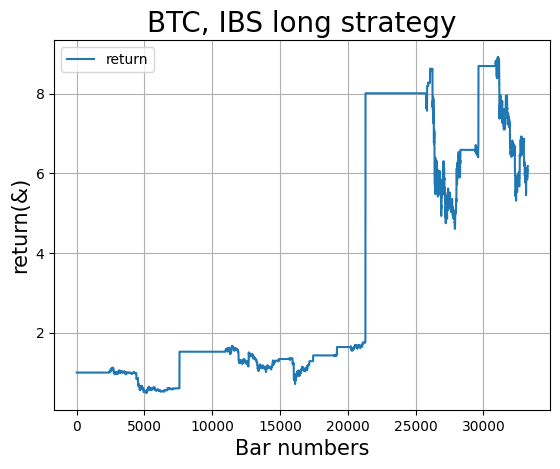

In [28]:
# Let's plot return
plt.plot(df['total'], label = 'return')
plt.ylabel('return(&)', fontsize = 15 )
plt.xlabel('Bar numbers', fontsize = 15 )
plt.title('BTC, IBS long strategy', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

# Let's test IBS short strategy

In [12]:
# short 진입청산 컬럼 생성
df['entry_short'] = np.where((df['short']==True)&(df['short_con']==True), 1.0,0.0) # 진입신호
df['exit_short'] = np.where(df['long']==True, 1.0,0.0) # 청산신호

In [13]:
# 포지션 보유 여부 컬럼 생성
df['position_short'] = df['entry_short'] - df['exit_short']

# remove duplicated position signal
lastseen = 0

for n,el in enumerate(df["position_short"]):
    # deal with edge case
    if lastseen == 0 and el == -1:
        df.loc[n,'position_short'] = 0
    
    if (el in [1, -1] and el != lastseen) or lastseen == 0:
        lastseen = el
    else:
        df.loc[n,"position_short"] = 0

In [14]:
df.loc[(df.position_short==1)|(df.position_short==-1),:]

,date,symbol,open,high,low,close,long,short,200SMA,100SMA,long_con,short_con,entry_short,exit_short,position_short
Bar numbers,,,,,,,,,,,,,,,
2446,2018-08-25 04:00:00,BTC/USD,6724.14,6745.75,6690.26,6738.99,False,True,NaN,6993.554733,True,True,1.0,0.0,1.0
2451,2018-08-25 09:00:00,BTC/USD,6708.17,6727.92,6682.93,6687.75,True,False,NaN,6990.205825,True,True,0.0,1.0,-1.0
2452,2018-08-25 10:00:00,BTC/USD,6687.75,6717.23,6682.23,6712.65,False,True,NaN,6989.541142,True,True,1.0,0.0,1.0
2462,2018-08-25 20:00:00,BTC/USD,6710.33,6724.99,6705.01,6705.09,True,False,NaN,6983.091367,True,True,0.0,1.0,-1.0
2473,2018-08-26 07:00:00,BTC/USD,6600.00,6636.00,6597.14,6634.00,False,True,NaN,6976.849063,True,True,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31114,2021-12-01 16:00:00,BTC/USD,58690.42,59099.64,58448.18,58509.33,True,False,46080.161469,54308.085317,False,True,0.0,1.0,-1.0
31119,2021-12-01 21:00:00,BTC/USD,56814.71,57070.28,56469.22,57045.41,False,True,46089.815300,54324.588263,False,True,1.0,0.0,1.0
31158,2021-12-03 12:00:00,BTC/USD,57047.03,57242.89,56809.71,56854.87,True,False,46171.900323,54457.099471,True,True,0.0,1.0,-1.0


## Visualize

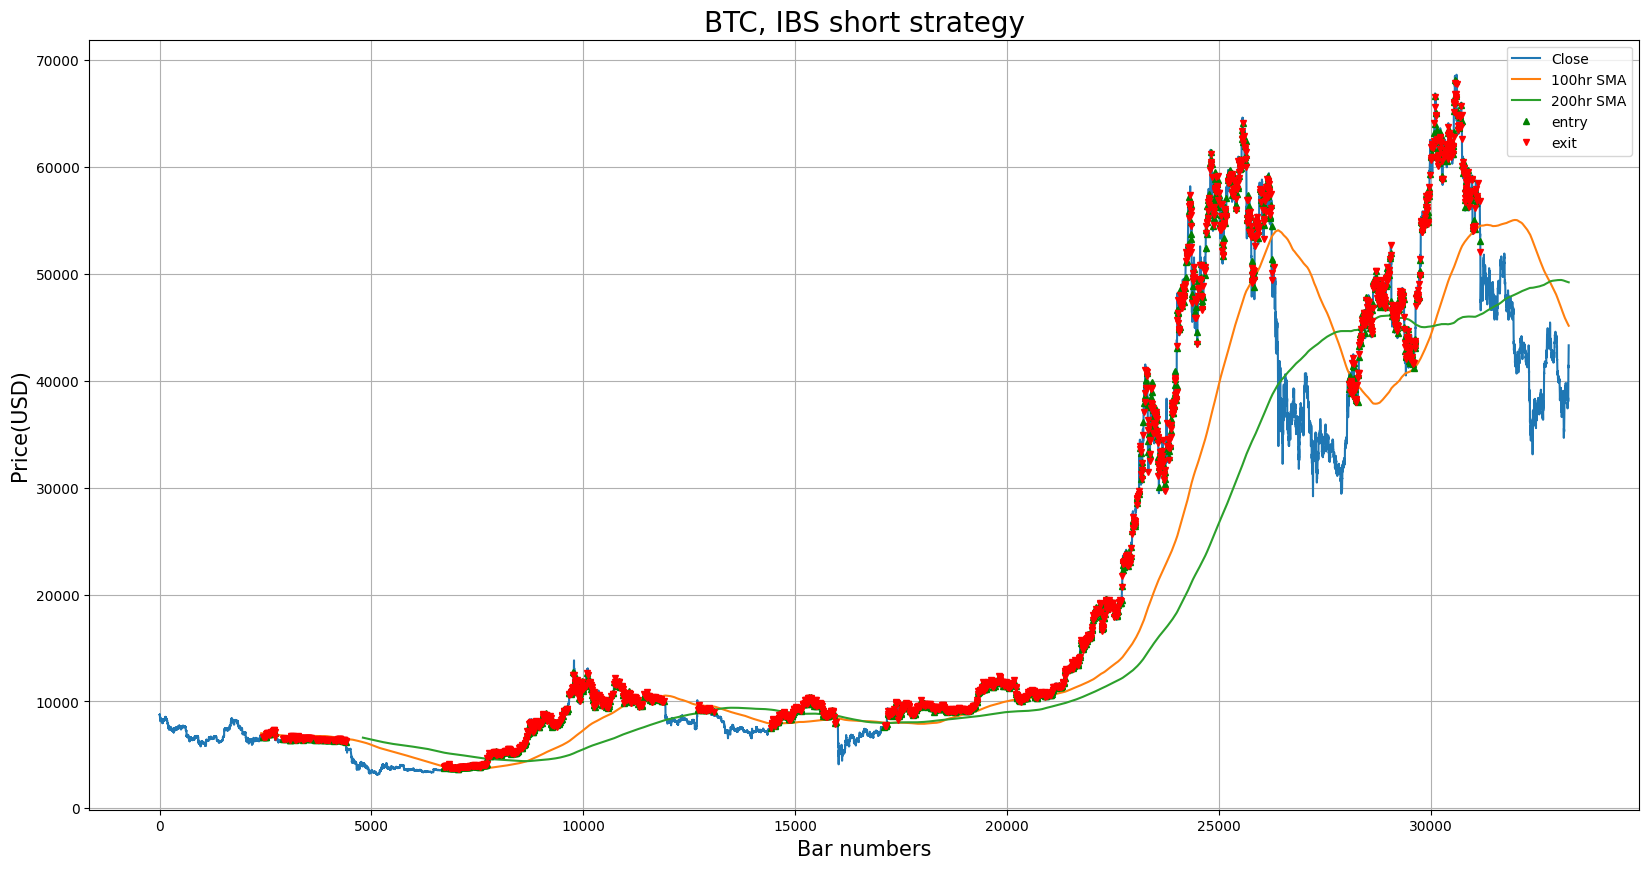

In [15]:
# plot close, 100SMA, 200SMA
df['close'].plot(figsize=(20,10), label='Close')
df['100SMA'].plot(label='100hr SMA')
df['200SMA'].plot(label='200hr SMA')

# plot 'entry' signals
plt.plot(df.loc[df['position_short']==1,:].index, df.loc[df['position_short']==1.0,'close'], '^', markersize = 5, color = 'g', label = 'entry')

# plot 'exit' signals
plt.plot(df.loc[df['position_short']==-1,:].index, df.loc[df['position_short']==-1.0,'close'], 'v', markersize = 5,  color = 'r', label = 'exit')
plt.ylabel('Price(USD)', fontsize = 15 )
plt.xlabel('Bar numbers', fontsize = 15 )
plt.title('BTC, IBS short strategy', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

## calculate the return

In [16]:
# make dataframe with position == 1 or position == -1
df2 = df.loc[(df.position_short==1)|(df.position_short==-1),:]
df2['exit_close_short'] = df2['close'].shift(-1)
# calculate return
df2['ror'] = df2['close']/df2['exit_close_short']

<ipython-input-16-19b2bb1e436e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['exit_close_short'] = df2['close'].shift(-1)
<ipython-input-16-19b2bb1e436e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['ror'] = df2['close']/df2['exit_close_short']


In [17]:
df['ror_short'] = df2['ror']
df['ror_short'].fillna(1,inplace=True)
# calculate accumulated ror
df['total_short'] = df['ror_short'].cumprod()

In [19]:
# calculate performance indicator

# return trading days
trade_day = int(len(df.index)/24)
result = round((df['total_short'].iat[-1] / df['total_short'].iat[0] - 1)*100, 3)

print(trade_day,'days / ', result,'return(%)')

1385 days /  -87.052 return(%)


## Let's twist the short strategy

* In bull market, short strategy can jeaperdize our account and give us huge loss

* We have several method to avoid this

 1) Trade only in bear market (ex. close < 100SMA)
 
 2) Minimize holding period

 3) Trade only in volatile market

In [ ]:
# Let's minimize the holding period
